In [116]:
import os
cwd = os.getcwd()
print(cwd)

C:\Users\111897


In [119]:
import pyodbc
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

In [148]:
cnxn = pyodbc.connect(driver='{SQL Server}', server='10.11.48.12', database='FZSRD_BD',               
               trusted_connection='yes')

#sql = 'SELECT top 10 * FROM v_customer_數位帳戶客戶'
sql = "SELECT top 50000 * FROM v_henry_A where 員工記號"

data=pd.read_sql(sql, cnxn)

print(data.columns)

cnxn.close()

Index(['UNINO', 'ID_NBR', 'ID_ERR', 'BUS', 'BIRTH', 'EDU', 'F_EXPIRY',
       'HOME_ZIP', 'INCOME', 'OWNERSHIP', 'OCC', 'MARR', 'COMP_NAME',
       'STMT_ZIP', 'L_MAINT_DT', 'COMP_ZIP', 'MAIL_IND', 'PERM_ZIP',
       'SYS_DATE', '性別', 'age', '年齡級距', '員工記號', '行業別', '行業別_分類', 'bus_edesc',
       'OWNER_DESC', '現居地所有權', '教育程度', '現居地_區域', 'home_dist', '現居地_縣市',
       'home_city', '現居地_縣市_英', '年收入', 'Salary', 'OCC_DESC', '職稱別', 'GRP_DESC',
       '職稱別_分類', '姻婚狀態', 'marry_status', '公司名稱', '資料更新日', '戶籍_區域', 'perm_dist',
       '戶籍_縣市', 'perm_city', '公司_區域', 'comp_dist', '公司_縣市', 'comp_city', '星座',
       '存戶最早開戶日', '台外幣總存款餘額_等值台幣', '台幣總存款餘額', '外幣總存款餘額_等值台幣', '台幣定存總存款餘額',
       'MMA網銀會員', 'MMA網路服務記號', '曾登入行動銀行', 'JCIC記號', 'JCIC_無擔保貸款金額_千元',
       'JCIC_無擔保貸款金額_千元_他行', 'JCIC_信用卡_最近分期餘額', 'JCIC_信用卡_最近分期餘額_他行',
       'JCIC_信用卡_最近分期銀行數', 'JCIC_中期貸款餘額', 'JCIC_長期貸款餘額', 'JCIC_授信異常記號',
       'JCIC_近半年增債金額_千元', 'JCIC_他行卡片最高等級', 'JCIC_他行近一年年收入均值', 'JCIC_DBR倍數',
       '月總AP_202006', '月放款AP_202006',

In [171]:
data_dn = data.dropna()
#data.info()

In [168]:
ap_data = data[["性別","age","行業別_分類","現居地_區域","戶籍_區域","Salary","姻婚狀態","星座","曾登入行動銀行","季投資理財AP_2020Q2"]]

ap_data = ap_data.dropna()
ap_data.head(5)
ap_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 40457 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   性別              40457 non-null  object 
 1   age             40457 non-null  float64
 2   行業別_分類          40457 non-null  object 
 3   現居地_區域          40457 non-null  object 
 4   戶籍_區域           40457 non-null  object 
 5   Salary          40457 non-null  float64
 6   姻婚狀態            40457 non-null  object 
 7   星座              40457 non-null  object 
 8   曾登入行動銀行         40457 non-null  object 
 9   季投資理財AP_2020Q2  40457 non-null  float64
dtypes: float64(3), object(7)
memory usage: 3.4+ MB


In [169]:
ap_data.describe()

,age,Salary,季投資理財AP_2020Q2
count,40457.000000,40457.000000,40457.000000
mean,45.090738,85.993976,244.634000
std,15.315580,123.497246,5189.727543
min,1.000000,0.000000,-2165.929549
25%,33.000000,26.000000,0.000000
50%,40.000000,49.000000,0.000000
75%,58.000000,82.900000,0.000000
max,108.000000,999.900000,421812.043765


In [166]:
Q1 = ap_data.quantile(0.25)
Q3 = ap_data.quantile(0.75)
IQR = Q3 - Q1

a = Q1
print("{0} \n".format(a))

a = Q3
print("{0} \n".format(a))

a = IQR
print("{0} \n".format(a))


age               33.0
Salary            26.0
月投資理財AP_202006     0.0
Name: 0.25, dtype: float64 

age               58.0
Salary            82.9
月投資理財AP_202006     0.0
Name: 0.75, dtype: float64 

age               25.0
Salary            56.9
月投資理財AP_202006     0.0
dtype: float64 



In [ ]:
ap_data = ap_data[(ap_data["Salary"]>=Q1["Salary"]-IQR["Salary"]*1.5) & (ap_data["Salary"]<=Q3["Salary"]+IQR["Salary"]*1.5)]
ap_data = ap_data[(ap_data["月投資理財AP_202006"]>=Q1["月投資理財AP_202006"]-IQR["月投資理財AP_202006"]*1.5) & (ap_data["月投資理財AP_202006"]<=Q3["月投資理財AP_202006"]+IQR["月投資理財AP_202006"]*1.5)]

In [155]:
#用tableau 檢查為何AP都是0
ap_data.describe()

,age,Salary,月投資理財AP_202006
count,35013.000000,35013.000000,35013.0
mean,45.018422,51.000214,0.0
std,15.239350,32.723878,0.0
min,1.000000,0.000000,0.0
25%,33.000000,25.000000,0.0
50%,40.000000,42.900000,0.0
75%,57.000000,67.300000,0.0
max,108.000000,162.500000,0.0


In [140]:
#ap_data = data[["性別","age","行業別_分類","現居地_區域","戶籍_區域","Salary","姻婚狀態","星座","曾登入行動銀行","月投資理財AP_202006"]]

ap_label = ap_data["月投資理財AP_202006"]
ap_data = ap_data.drop('月投資理財AP_202006',axis=1)

ap_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18140 entries, 2 to 49992
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   性別       18140 non-null  object 
 1   age      18140 non-null  float64
 2   行業別_分類   18140 non-null  object 
 3   現居地_區域   18140 non-null  object 
 4   戶籍_區域    18140 non-null  object 
 5   Salary   18140 non-null  float64
 6   姻婚狀態     18140 non-null  object 
 7   星座       18140 non-null  object 
 8   曾登入行動銀行  18140 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.4+ MB


In [141]:
#data.describe().T
ap_data.describe()

,age,Salary
count,18140.000000,18140.000000
mean,42.735667,93.594019
std,9.050146,116.903868
min,14.000000,0.000000
25%,38.000000,33.800000
50%,42.000000,60.000000
75%,48.000000,100.000000
max,176.000000,999.900000


In [170]:
#data["行業別"].value_counts().to_frame()
#ap_data_dn["行業別_分類"].value_counts().to_frame()
ap_data["曾登入行動銀行"].value_counts().to_frame()
data["員工記號"].value_counts().to_frame()

,員工記號
Y,205


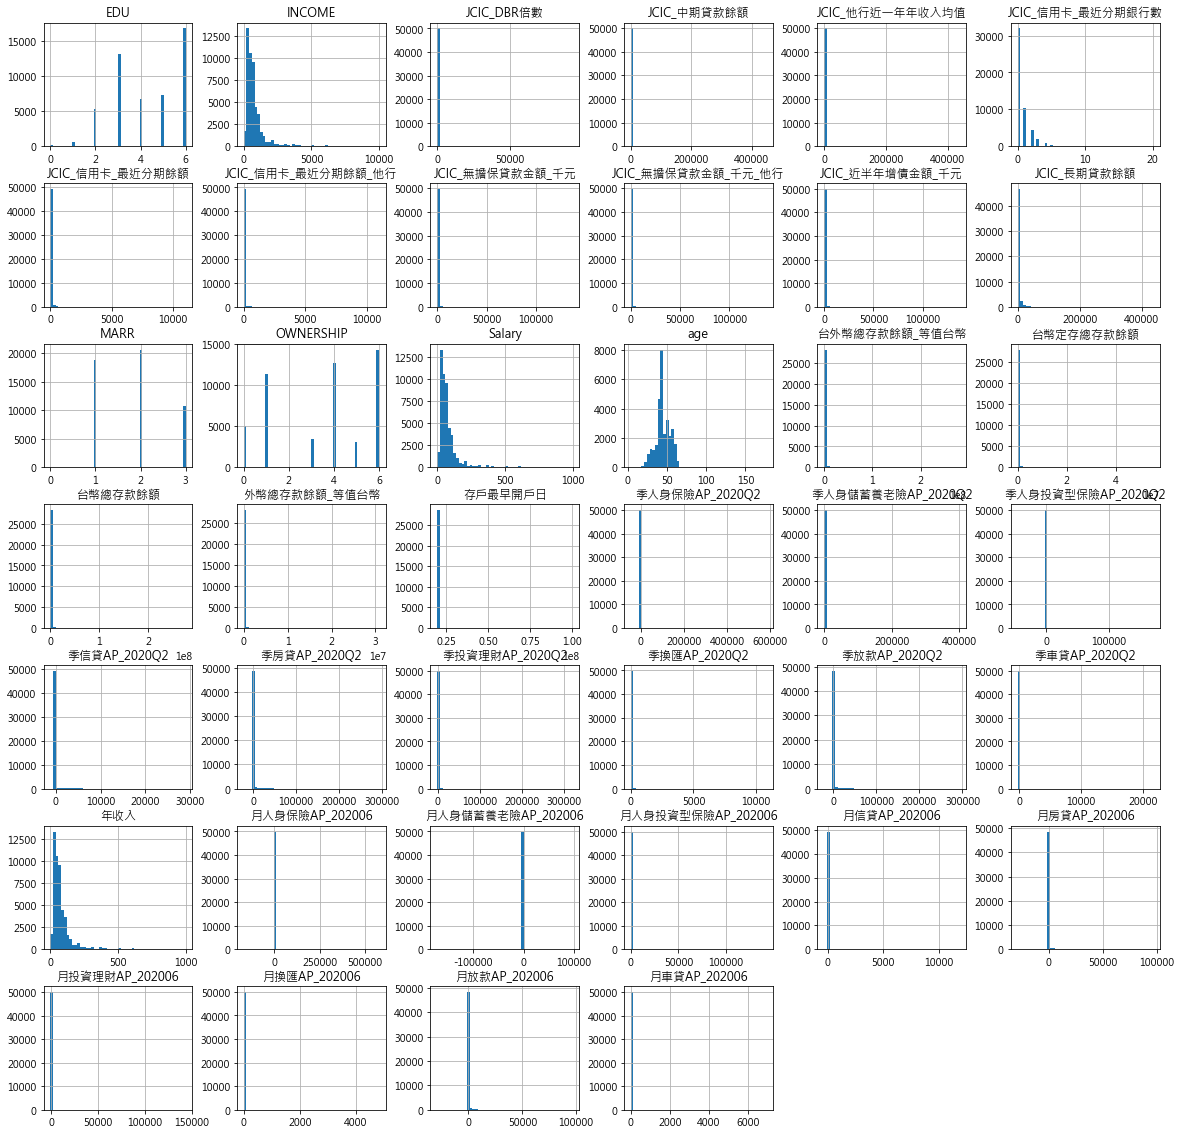

In [127]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

data.hist(bins=50, figsize=(20,20))
plt.show()

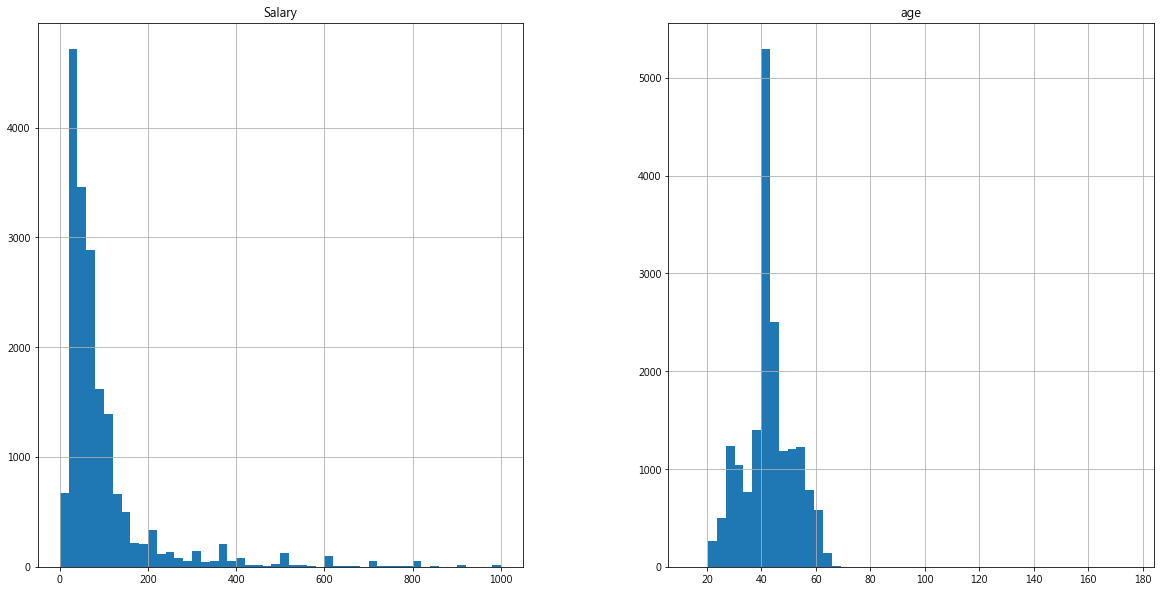

In [143]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.sans-serif':'Microsoft JhengHei', 
    'axes.unicode_minus':False})

ap_data.hist(bins=50, figsize=(20,10))
plt.show()


In [145]:
a = ap_data.shape 
print("{0}".format(a))

a = ap_label.shape 
print("{0}".format(a))

(18140, 9)
(18140,)


In [146]:
from sklearn.model_selection import train_test_split

train_ap_data, test_ap_data, train_ap_label, test_ap_label = train_test_split(ap_data, ap_label)


In [131]:
ap_data.info()
#train_ap_data.info()
#test_ap_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18140 entries, 2 to 49992
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   性別       18140 non-null  object 
 1   age      18140 non-null  float64
 2   行業別_分類   18140 non-null  object 
 3   現居地_區域   18140 non-null  object 
 4   戶籍_區域    18140 non-null  object 
 5   Salary   18140 non-null  float64
 6   姻婚狀態     18140 non-null  object 
 7   星座       18140 non-null  object 
 8   曾登入行動銀行  18140 non-null  object 
dtypes: float64(2), object(7)
memory usage: 1.4+ MB


In [ ]:
#a = data.shape
#print("#1:table 列數及欄位數 \n {0} \n\n".format(a))

pd.set_option('display.precision', 2)# sets the output display precision in terms of decimal places. This is only a suggestion.
pd.set_option('colheader_justify', 'right')

pd.set_option('display.html.table_schema', True)
pd.set_option('display.html.border', 2)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

a = data.info(verbose=True)
print("#2:資料Non-Null筆數及資料格式\n {0} \n\n".format(a))


a = data.describe()
print("#3:資料描述\n {0} \n\n".format(a))
